# Biased initial samples

This example walks through correcting a biased set of initial samples
to recover the true posterior using Aspire's flow-based samplers.


## Set up the environment
Import the core scientific stack along with Aspire utilities for logging,
plotting, and handling sample collections.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.stats import norm, uniform, expon

from aspire import Aspire
from aspire.samples import Samples
from aspire.utils import configure_logger, AspireFile
from aspire.plot import plot_comparison

# Configure the logger
configure_logger("INFO")


<Logger aspire (INFO)>

## Configure output paths
Create a reproducible random number generator and ensure the directory used to
store figures and results exists.


In [2]:

outdir = Path("outdir") / "biased_example"
outdir.mkdir(parents=True, exist_ok=True)

rng = np.random.default_rng(42)


## Describe the target distribution
Specify the one-dimensional marginals that define our four-dimensional target
and wrap them in likelihood and prior helper functions consumed by Aspire.


In [3]:

dists = [
    norm(loc=6, scale=0.2),
    expon(scale=1),
    norm(loc=5, scale=1),
    uniform(loc=-10, scale=20),
]

prior_bounds = [
    (-10, 10),
    (0, 10),
    (-10, 10),
    (-10, 10),
]
dims = len(dists)
parameters = [f"x_{i}" for i in range(dims)]


def log_likelihood(samples: Samples):
    x = samples.x
    log_prob = np.zeros(x.shape[0])
    for i, dist in enumerate(dists):
        log_prob += dist.logpdf(x[:, i])
    return log_prob


def log_prior(samples: Samples):
    log_prob = np.zeros(samples.x.shape[0])
    for i, bounds in enumerate(prior_bounds):
        log_prob += uniform(bounds[0], bounds[1] - bounds[0]).logpdf(samples.x[:, i])
    return log_prob



## Draw biased initial samples
Generate intentionally biased proposal samples alongside reference draws from
the true distribution, then instantiate the `Aspire` object that will learn a
correcting flow.


In [4]:

n_init = 1_000

x_initial = np.concatenate([
    rng.normal(loc=2, scale=1, size=(n_init, 1)),
    rng.exponential(scale=1, size=(n_init, 1)),
    rng.normal(loc=0, scale=1, size=(n_init, 1)),
    # rng.uniform(low=-10, high=10, size=(n_init, 1)),
    rng.uniform(low=-10, high=10, size=(n_init, 1)),
], axis=1)

x_true = np.concatenate([
    dist.rvs(size=(n_init, 1), random_state=rng) for dist in dists
], axis=1)

dims = x_initial.shape[1]
parameters = [f"x_{i}" for i in range(dims)]
initial_samples = Samples(
    x=x_initial,
    parameters=parameters,
)
true_samples = Samples(
    x=x_true,
    parameters=parameters,
)
# Define the parameters and prior bounds
prior_bounds_dict = {p: b for p, b in zip(parameters, prior_bounds)}

# Define the aspire object
poppy = Aspire(
    log_likelihood=log_likelihood,
    log_prior=log_prior,
    dims=dims,
    parameters=parameters,
    prior_bounds=prior_bounds_dict,
    flow_matching=False,
    flow_backend="zuko",
    bounded_to_unbounded=True,
    hidden_features=[32, 32],
    device="cpu",
)


## Train the flow model
Fit the normalizing flow to the initial samples and monitor optimisation via
the loss curve.


2025-11-05 17:45:18,424 - aspire - INFO - Prior bounds: {'x_0': (-10, 10), 'x_1': (0, 10), 'x_2': (-10, 10), 'x_3': (-10, 10)}
2025-11-05 17:45:18,425 - aspire - INFO - Bounded parameters: ['x_0', 'x_1', 'x_2', 'x_3']
2025-11-05 17:45:18,426 - aspire - INFO - Affine transform applied to: ['x_0', 'x_1', 'x_2', 'x_3']
2025-11-05 17:45:18,427 - aspire - INFO - Configuring <class 'aspire.flows.torch.flows.ZukoFlow'> with kwargs: {'hidden_features': [32, 32]}
2025-11-05 17:45:19,919 - aspire - INFO - Initialized normalizing flow: 
 MAF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1, 2, 3]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=8, bias=True)
      )
    )
    (1): MaskedAutoregressi

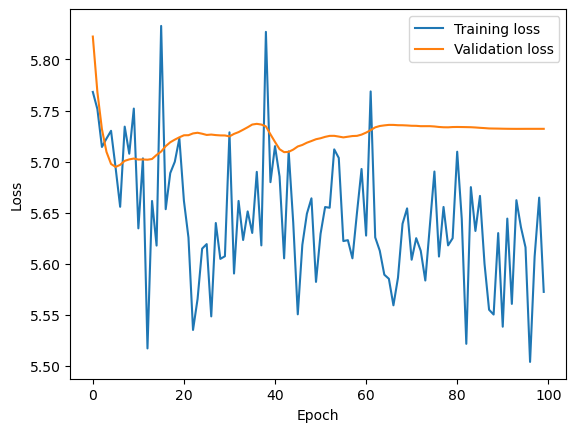

In [5]:

# Fit the flow to the initial samples
history = poppy.fit(
    initial_samples,
    n_epochs=100,
    lr_annealing=True,
    batch_size=256,
)
# Plot the loss
fig = history.plot_loss()
fig.savefig(outdir / "loss.png")
plt.show()

## Compare flow-based importance samples
Use the trained flow to generate new samples, and visualise how they compare to
the original biased set and the ground truth.


2025-11-05 17:45:21,954 - aspire - INFO - Sampled 10000 samples from the posterior
2025-11-05 17:45:21,954 - aspire - INFO - Number of likelihood evaluations: 10000
2025-11-05 17:45:21,955 - aspire - INFO - Sample summary:
2025-11-05 17:45:21,955 - aspire - INFO - No. samples: 10000
No. parameters: 4
Log evidence: -27.71 +/- 0.86
Effective sample size: 1.3
Efficiency: 0.00



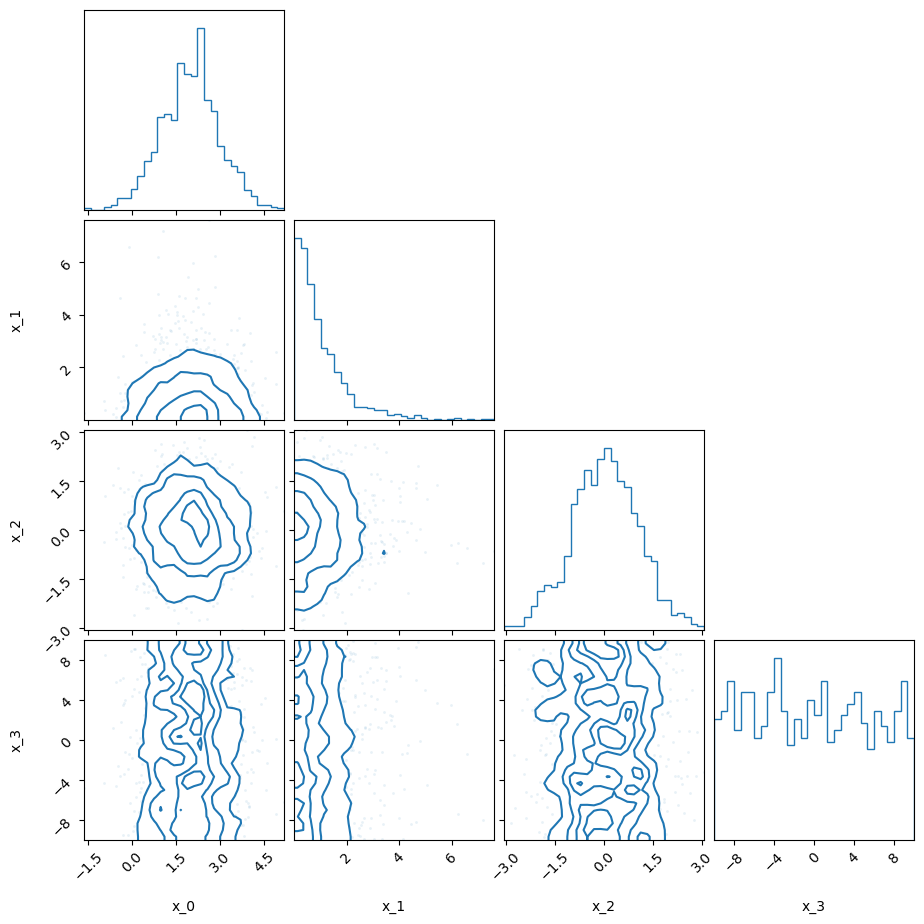

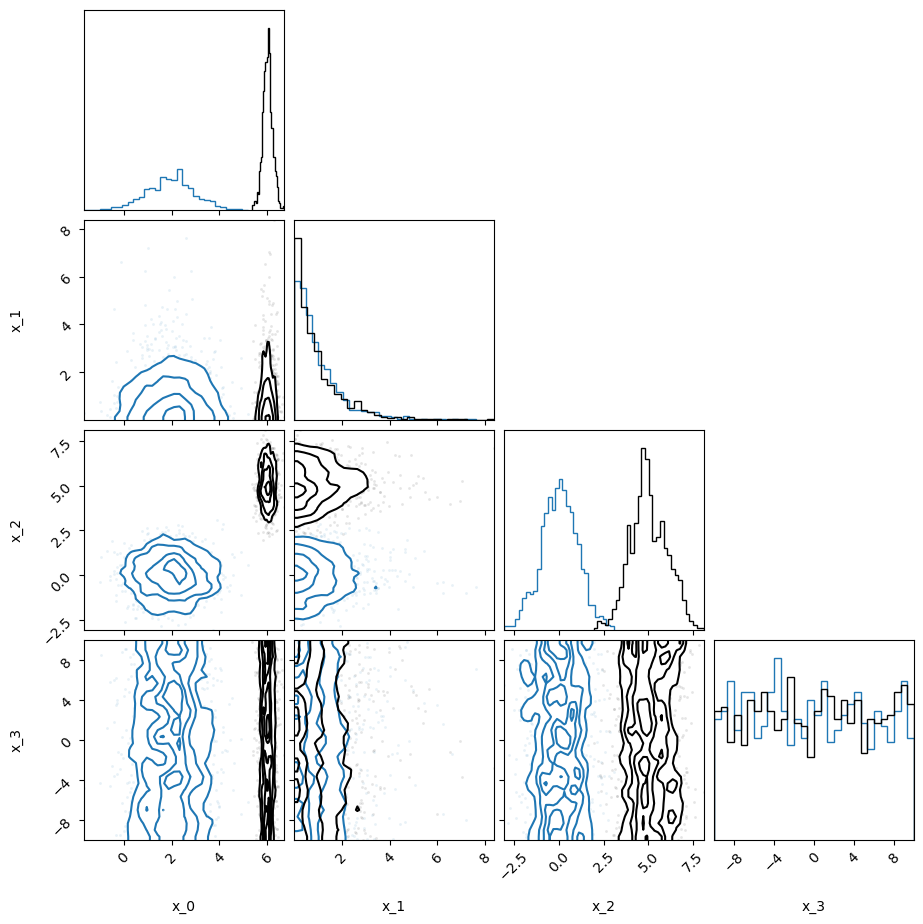

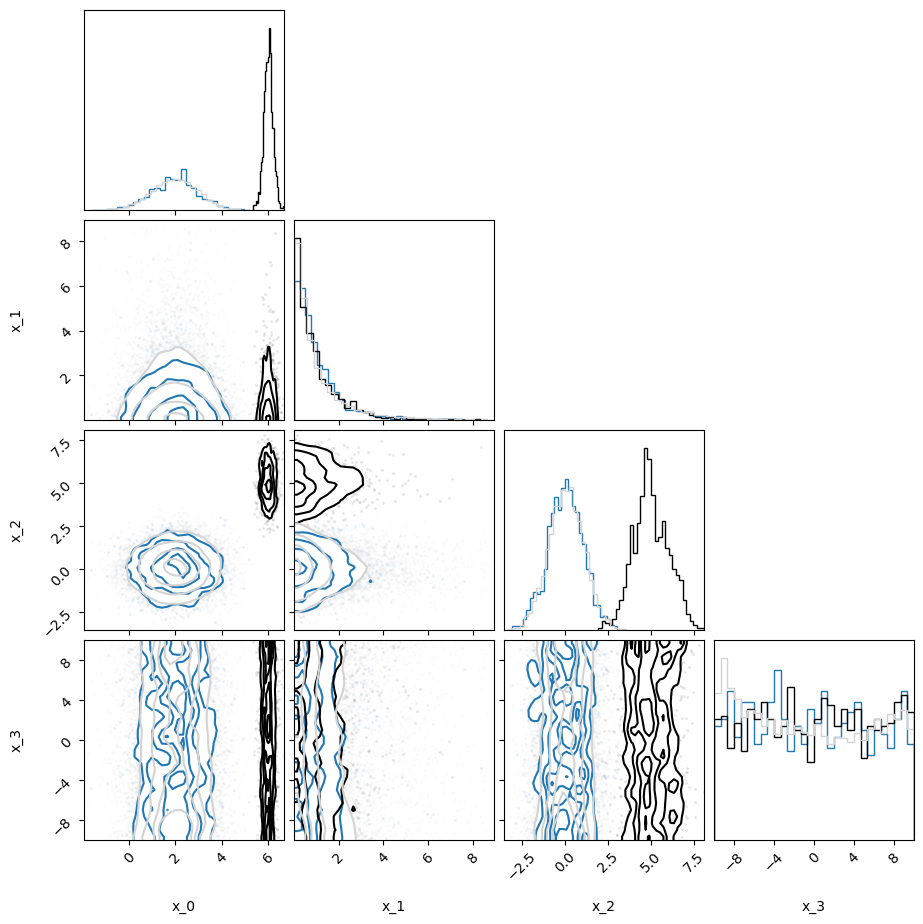

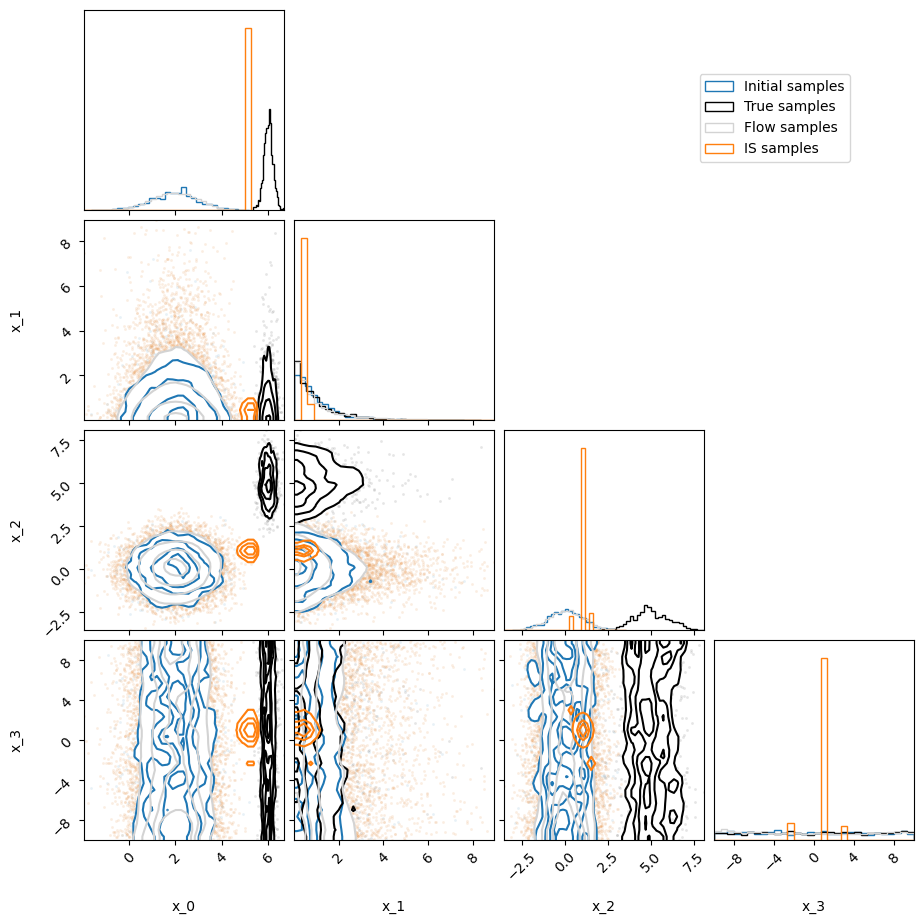

In [6]:

is_samples = poppy.sample_posterior(10_000)


fig = plot_comparison(
    initial_samples,
    true_samples,
    is_samples,
    is_samples,
    per_samples_kwargs=[
        dict(include_weights=True, color="C0"),
        dict(include_weights=False, color="k"),
        dict(include_weights=False, color="lightgrey"),
        dict(include_weights=True, color="C1"),
    ],
    labels=["Initial samples", "True samples", "Flow samples", "IS samples"],
)
fig.savefig(outdir / "initial_samples.png")
plt.show()


## Refine with sequential Monte Carlo
Run Aspire's SMC sampler to further correct the proposal and inspect the
particle evolution.


2025-11-05 17:45:23,620 - aspire - INFO - Prior bounds: {'x_0': (-10, 10), 'x_1': (0, 10), 'x_2': (-10, 10), 'x_3': (-10, 10)}
INFO:aspire.transforms:Prior bounds: {'x_0': (-10, 10), 'x_1': (0, 10), 'x_2': (-10, 10), 'x_3': (-10, 10)}
2025-11-05 17:45:23,621 - aspire - INFO - Prior bounds: {'x_0': array([-10,  10]), 'x_1': array([ 0, 10]), 'x_2': array([-10,  10]), 'x_3': array([-10,  10])}
INFO:aspire.transforms:Prior bounds: {'x_0': array([-10,  10]), 'x_1': array([ 0, 10]), 'x_2': array([-10,  10]), 'x_3': array([-10,  10])}
2025-11-05 17:45:23,621 - aspire - INFO - Affine transform applied to: ['x_0', 'x_1', 'x_2', 'x_3']
INFO:aspire.transforms:Affine transform applied to: ['x_0', 'x_1', 'x_2', 'x_3']
2025-11-05 17:45:23,631 - aspire - INFO - it 1 - beta: 0.0118408203125
INFO:aspire.samplers.smc.base:it 1 - beta: 0.0118408203125
2025-11-05 17:45:23,632 - aspire - INFO - it 1 - ESS: 500.3 (0.50 efficiency)
INFO:aspire.samplers.smc.base:it 1 - ESS: 500.3 (0.50 efficiency)
2025-11-05 

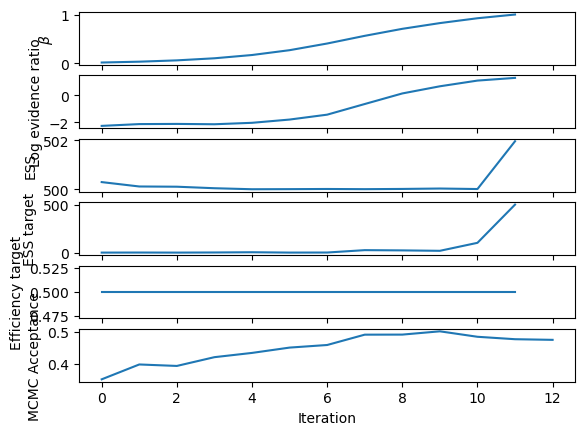

In [ ]:

# Produce samples from the posterior
samples, smc_history = poppy.sample_posterior(
    1000,
    sampler="smc",
    return_history=True,
    n_final_samples=10_000,
    sampler_kwargs=dict(
        n_steps=32,
    ),
)

fig = smc_history.plot()
fig.savefig(outdir / "history.png")


## Persist results
Write the flow history, SMC diagnostics, and posterior samples to disk so the
analysis can be reproduced or extended.


In [8]:

# Save the the results to a file
# The AspireFile is a small wrapper around h5py.File that automatically
# includes additional metadata
with AspireFile(outdir / "poppy_result.h5", "w") as f:
    # poppy.save_config(f, "poppy_config")
    samples.save(f, "smc/posterior_samples")
    history.save(f, "flow/history")
    smc_history.save(f, "smc/history")



## Final posterior comparison
Contrast the SMC posterior samples against the earlier flow draws to check that
corrections removed the bias.


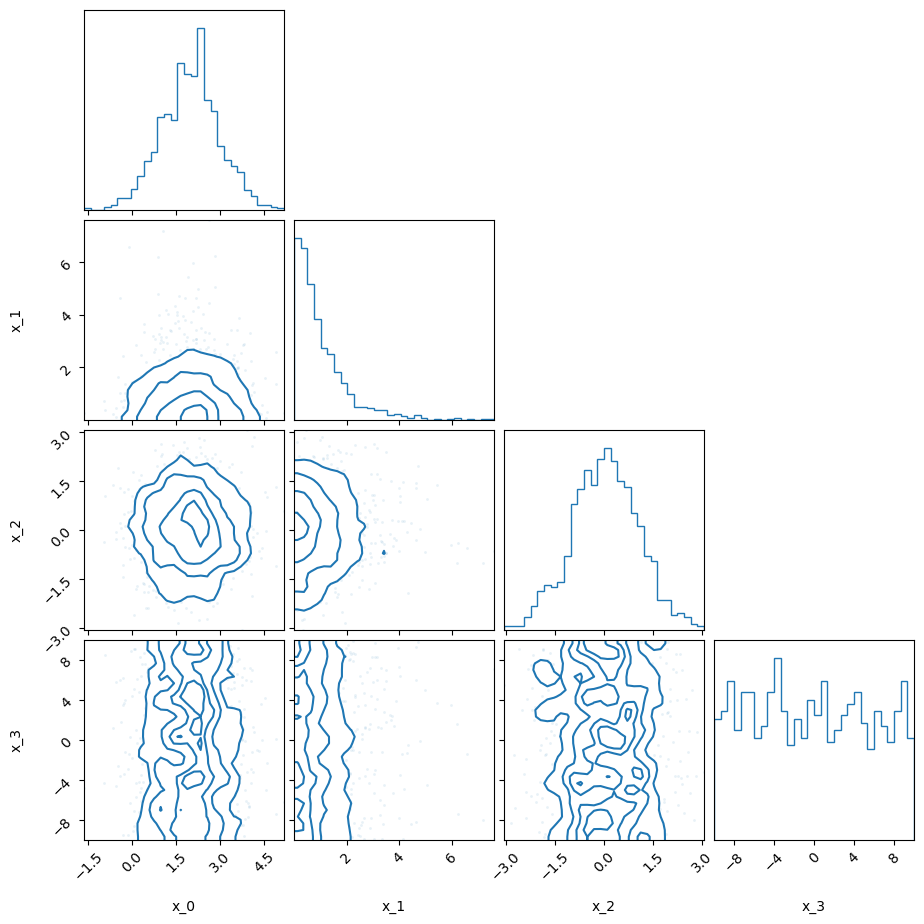

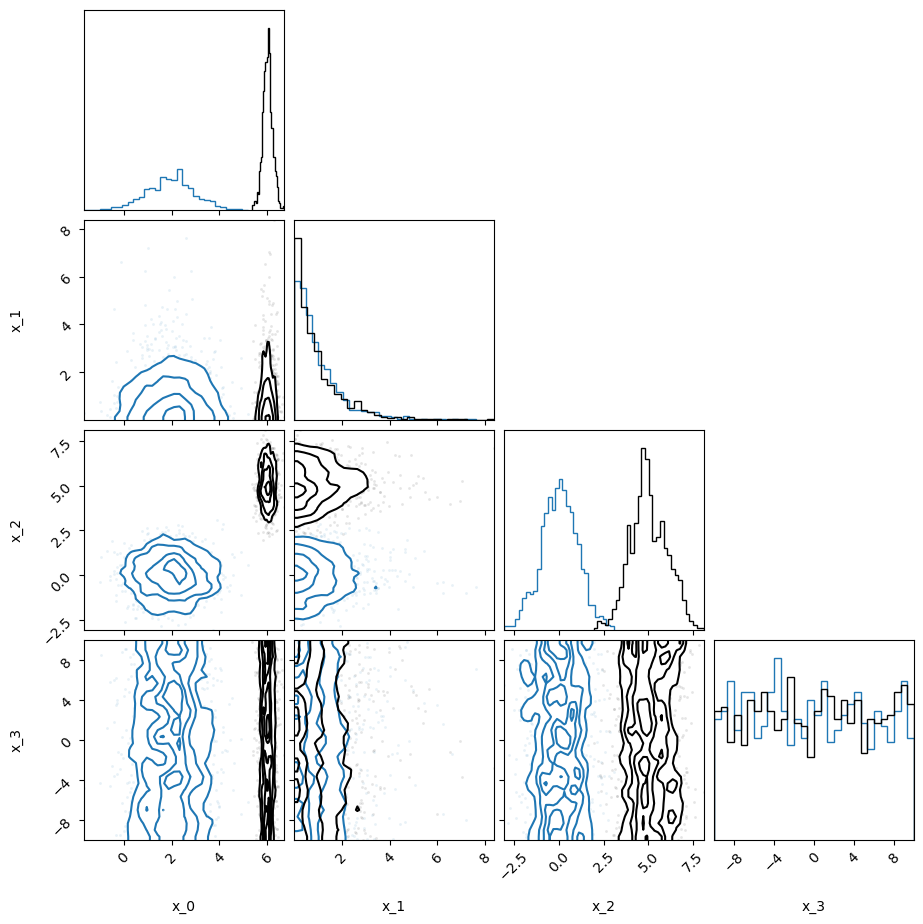

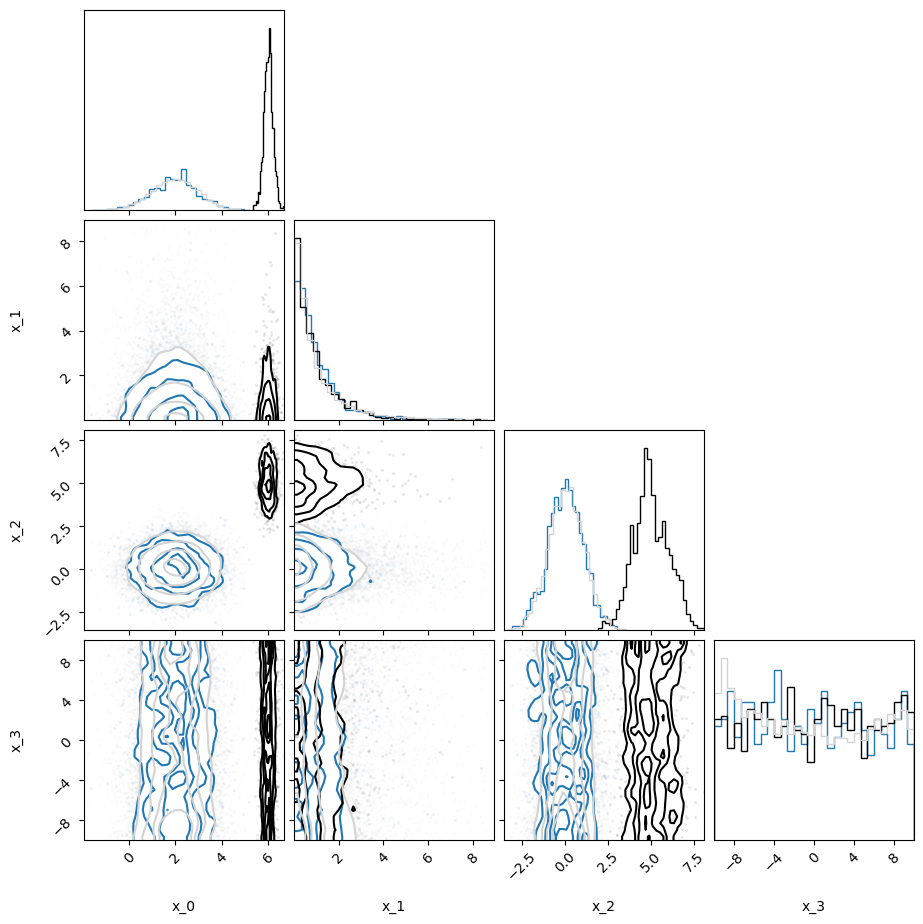

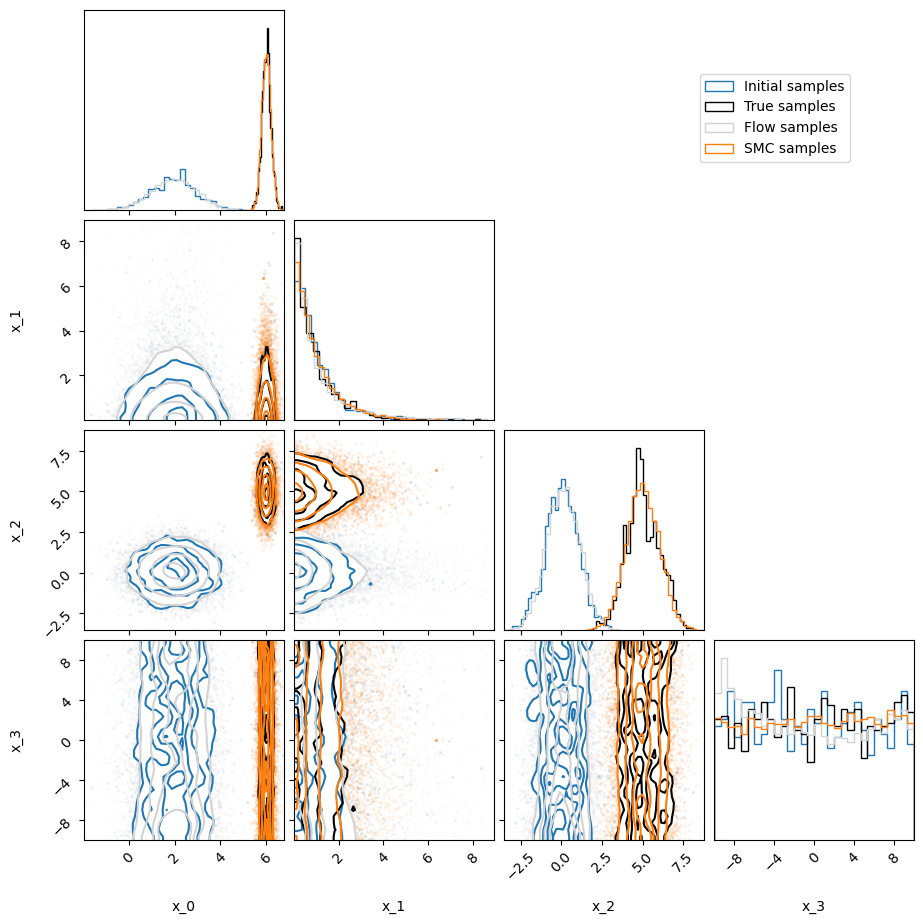

In [9]:


fig = plot_comparison(
    initial_samples,
    true_samples,
    is_samples,
    samples,
    per_samples_kwargs=[
        dict(include_weights=True, color="C0"),
        dict(include_weights=False, color="k"),
        dict(include_weights=False, color="lightgrey"),
        dict(include_weights=False, color="C1"),
    ],
    labels=["Initial samples", "True samples", "Flow samples", "SMC samples"],
)
fig.savefig(outdir / "posterior_samples.png")
plt.show()